# Clustering

Il clustering consiste nel trovare, all'interno di un dataset dove i dati non sono etichettati, delle similarità fra questi ultimi, per raggrupparli in cluster a cui in seguito dare una etichetta.

Non esiste, a differenza di altre categorie di algoritmi, una maniera assoluta di misurare la bontà di un modello. Nella classificazione ad esempio, le classi in cui far rientrare gli elementi presi in analisi sono conosciute a priori; nel clustering invece, queste classi vanno trovate "a mano" analizzando i pattern dei dati.

Per le caratteristiche appena illustrate, gli algoritmi di clustering vengono definiti algoritmi di learning non supervisionato.

**Algoritmo k-means**





L'idea dell'algoritmo k-means è scegliere a priori un numero k e dividere i dati in input, in questo caso vettori bidimensionali, in k partizioni in modo da minimizzare il quadrato della distanza di ciascun punto dalla media (il centro) del proprio cluster.



In [21]:
import random
random.seed(12)
# punti di cui trovare cluster
inputs = [[-14,-5],[13,13],[20,23],[-19,-11],[-9,-16],[21,27],[-49,15],[26,13],[-46,5],[-34,-1],[11,15],[-49,0],[-22,-16],[19,28],[-12,-8],[-13,-19],[-41,8],[-11,-6],[-25,-9],[-18,-3]]


*   Visualizzazione dei punti su cui lavorare


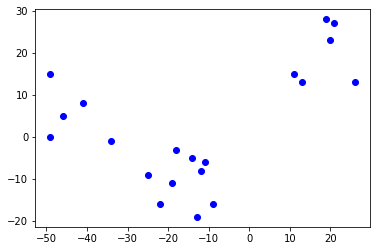

In [31]:
from matplotlib import pyplot as plt

for point in inputs:
  plt.scatter(point[0], point[1], c="blue")



*   Il modulo linear_algebra contiene le definizioni di alcune operazioni di algebra lineare così come definite sul libro *Data science from scratch*.



La funzione `cluster_means` calcola i punti medi dei cluster.

In [44]:
from linear_algebra import Vector
from typing import List
from linear_algebra import vector_mean

def cluster_means(k, inputs, assignments):
    # clusters[i] contains the inputs whose assignment is i
    clusters = [[] for i in range(k)]
    for input, assignment in zip(inputs, assignments):
        clusters[assignment].append(input)

    # if a cluster is empty, just use a random point
    return [vector_mean(cluster) if cluster else random.choice(inputs)
            for cluster in clusters]



*   I passi che l'algoritmo segue sono i seguenti: 

  1.   Definizione di k medie, ovvero punti d-dimensionali
  2.   Assegnazione di ogni punto in input alla media più vicina geometricamente
  3.   Se non c'è nessuna nuova assegnazione, termina
  4.   Se c'è una nuova assegnazione, ricalcola le medie e riparte dal punto 2







* L'implementazione dell'algotitmo in Python:




In [45]:
import itertools
import random
import tqdm
from linear_algebra import squared_distance

def num_differences(v1, v2):
    assert len(v1) == len(v2)
    return len([x1 for x1, x2 in zip(v1, v2) if x1 != x2])

class KMeans:
    def __init__(self, k: int) -> None:
        self.k = k                      # number of clusters
        self.means = None

    def classify(self, input: Vector) -> int:
        """return the index of the cluster closest to the input"""
        return min(range(self.k),
                   key=lambda i: squared_distance(input, self.means[i]))

    def train(self, inputs: List[Vector]) -> None:
        # Start with random assignments
        assignments = [random.randrange(self.k) for _ in inputs]

        with tqdm.tqdm(itertools.count()) as t:
            for _ in t:
                # Compute means and find new assignments
                self.means = cluster_means(self.k, inputs, assignments)
                new_assignments = [self.classify(input) for input in inputs]

                # Check how many assignments changed and if we're done
                num_changed = num_differences(assignments, new_assignments)
                if num_changed == 0:
                    return

                # Otherwise keep the new assignments, and compute new means
                assignments = new_assignments
                self.means = cluster_means(self.k, inputs, assignments)
                t.set_description(f"changed: {num_changed} / {len(inputs)}")

* Test dell'algoritmo sui punti definiti inizialmente:

In [28]:
random.seed(12)                   
clusterer = KMeans(k=3)
clusterer.train(inputs)

changed: 5 / 20: : 0it [00:00, ?it/s]


[[-43.800000000000004, 5.4],
 [-15.888888888888888, -10.333333333333332],
 [18.333333333333332, 19.833333333333332]]



*   Visualizzazione dei centri dei 3 cluster (in rosso).



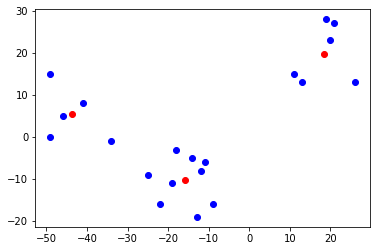

In [40]:
for point in inputs:
  plt.scatter(point[0], point[1], c="blue")
for point in clusterer.means:
  plt.scatter(point[0], point[1], c="red")



*   Cosa succede con *k*=2?



changed: 8 / 20: : 0it [00:00, ?it/s]


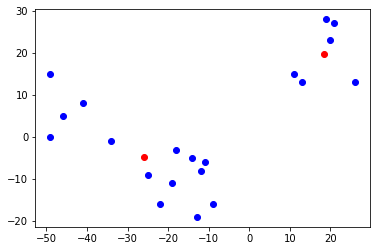

In [41]:
clusterer = KMeans(k=2)
clusterer.train(inputs)
for point in inputs:
  plt.scatter(point[0], point[1], c="blue")
for point in clusterer.means:
  plt.scatter(point[0], point[1], c="red")



*   Scelta di *k*





Un modo per trovare scegliere k è creare un grafico che mostra la somma dei quadrati delle distanze in funzione di k. In questo modo si può vedere con una sorta di piega sul grafico il punto dove la somma dei quadrati crolla rispetto a k.

In [42]:
from matplotlib import pyplot as plt
    
def squared_clustering_errors(inputs: List[Vector], k: int) -> float:
  """finds the total squared error from k-means clustering the inputs"""
  clusterer = KMeans(k)
  clusterer.train(inputs)
  means = clusterer.means
  assignments = [clusterer.classify(input) for input in inputs]
    
  return sum(squared_distance(input, means[cluster])
        for input, cluster in zip(inputs, assignments))



*   *k* ideale per i punti presi in esame precedentemente



In [ ]:
ks = range(1, len(inputs) + 1)
errors = [squared_clustering_errors(inputs, k) for k in ks]
    
plt.plot(ks, errors)
plt.xticks(ks)
plt.xlabel("k")
plt.ylabel("total squared error")
plt.title("Total Error vs. # of Clusters")

**Cluster gerarchico agglomerativo (bottom-up)**



1.   Ogni input è un cluster a sé
2.   Finchè ci sono più cluster, merge dei due cluster più vicini

Al termine di questa operazione rimarrà un solo cluster con tutti gli input. Tenendo però traccia del processo iterativo di mergine, possiamo ottenere una partizione in qualsiasi numero di cluster vogliamo.



In [101]:
from typing import NamedTuple, Union

class Leaf(NamedTuple):
    value: Vector

leaf1 = Leaf([10,  20])
leaf2 = Leaf([30, -15])

class Merged(NamedTuple):
    children: tuple
    order: int

merged = Merged((leaf1, leaf2), order=1)
Cluster = Union[Leaf, Merged]

* Creazione di una funzione per ottenere tutti i valori all'interno di un dato cluster:

In [102]:
def get_values(cluster: Cluster) -> List[Vector]:
    if isinstance(cluster, Leaf):
        return [cluster.value]
    else:
        return [value
                for child in cluster.children
                for value in get_values(child)]

* Nel punto 2. si parla di merging fra i due cluster più vicini. Per fare ciò bisogna definire la distanza tra cluster. Viene scelta la funzione *min*, che trova i due punti più vicini in due cluster differenti

In [103]:
from typing import Callable
from linear_algebra import distance

def cluster_distance(cluster1, cluster2, distance_agg: Callable = min):
    """
    compute all the pairwise distances between cluster1 and cluster2
    and apply the aggregation function _distance_agg_ to the resulting list
    """
    return distance_agg([distance(v1, v2)
                         for v1 in get_values(cluster1)
                         for v2 in get_values(cluster2)])



*   Funzione per ottenere l'ordine del merge. Le foglie hanno ordine infinito.


In [104]:
def get_merge_order(cluster):
    if isinstance(cluster, Leaf):
        return float('inf')  # was never merged
    else:
        return cluster.order

* Funzione per ottenere i *figli* di un cluster. Le foglie non hanno figli.

In [105]:
from typing import Tuple

def get_children(cluster):
    if isinstance(cluster, Leaf):
        raise TypeError("Leaf has no children")
    else:
        return cluster.children

* Implementazione dell'algoritmo bottom-up



In [106]:
def bottom_up_cluster(inputs, distance_agg: Callable = min):
    # Start with all leaves
    clusters: List[Cluster] = [Leaf(input) for input in inputs]

    def pair_distance(pair: Tuple[Cluster, Cluster]) -> float:
        return cluster_distance(pair[0], pair[1], distance_agg)

    # as long as we have more than one cluster left...
    while len(clusters) > 1:
        # find the two closest clusters
        c1, c2 = min(((cluster1, cluster2)
                      for i, cluster1 in enumerate(clusters)
                      for cluster2 in clusters[:i]),
                      key=pair_distance)

        # remove them from the list of clusters
        clusters = [c for c in clusters if c != c1 and c != c2]

        # merge them, using merge_order = # of clusters left
        merged_cluster = Merged((c1, c2), order=len(clusters))

        # and add their merge
        clusters.append(merged_cluster)

    # when there's only one cluster left, return it
    return clusters[0]

In [114]:
cluster = bottom_up_cluster(inputs)
cluster

Merged(children=(Merged(children=(Merged(children=(Merged(children=(Merged(children=(Leaf(value=[19, 28]), Leaf(value=[21, 27])), order=18), Leaf(value=[20, 23])), order=14), Leaf(value=[26, 13])), order=3), Merged(children=(Leaf(value=[11, 15]), Leaf(value=[13, 13])), order=16)), order=1), Merged(children=(Merged(children=(Merged(children=(Merged(children=(Merged(children=(Leaf(value=[-49, 0]), Leaf(value=[-46, 5])), order=11), Leaf(value=[-41, 8])), order=9), Leaf(value=[-49, 15])), order=5), Leaf(value=[-34, -1])), order=4), Merged(children=(Merged(children=(Merged(children=(Merged(children=(Leaf(value=[-22, -16]), Leaf(value=[-19, -11])), order=10), Leaf(value=[-25, -9])), order=8), Merged(children=(Merged(children=(Merged(children=(Leaf(value=[-11, -6]), Leaf(value=[-12, -8])), order=17), Leaf(value=[-14, -5])), order=15), Leaf(value=[-18, -3])), order=13)), order=7), Merged(children=(Leaf(value=[-13, -19]), Leaf(value=[-9, -16])), order=12)), order=6)), order=2)), order=0)

* Ora serve una funzione per ottenere dal singolo cluster, il numero di cluster desiderato

In [107]:
def generate_clusters(base_cluster, num_clusters):
    # start with a list with just the base cluster
    clusters = [base_cluster]

    # as long as we don't have enough clusters yet...
    while len(clusters) < num_clusters:
        # choose the last-merged of our clusters
        next_cluster = min(clusters, key=get_merge_order)
        # remove it from the list
        clusters = [c for c in clusters if c != next_cluster]

        # and add its children to the list (i.e., unmerge it)
        clusters.extend(get_children(next_cluster))

    # once we have enough clusters...
    return clusters

In [119]:
[get_values(c) for c in (generate_clusters(cluster, 3))]

[[[-49, 0],
  [-46, 5],
  [-41, 8],
  [-49, 15],
  [-34, -1],
  [-22, -16],
  [-19, -11],
  [-25, -9],
  [-11, -6],
  [-12, -8],
  [-14, -5],
  [-18, -3],
  [-13, -19],
  [-9, -16]],
 [[19, 28], [21, 27], [20, 23], [26, 13]],
 [[11, 15], [13, 13]]]



*   Visualizzazione del centro dei cluster generati:


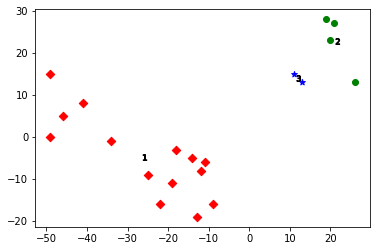

In [123]:
for i, c, marker, color in zip([1, 2, 3], [get_values(c) for c in (generate_clusters(cluster, 3))], ['D','o','*'], ['r','g','b']):
        xs, ys = zip(*c)  # magic unzipping trick
        plt.scatter(xs, ys, color=color, marker=marker)
    
        # put a number at the mean of the cluster
        x, y = vector_mean(c)
        plt.plot(x, y, marker='$' + str(i) + '$', color='black')



*   Cambiando la funzione di aggregazione passata a `cluster_distance` (di default è *min*), si otterrà un *clustering* diverso. Funzione di aggregazione *max*



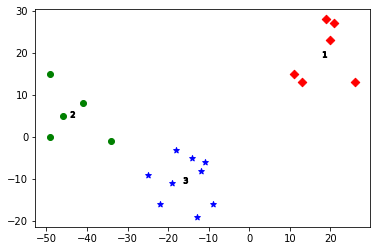

In [121]:
cluster2 = bottom_up_cluster(inputs, max)

for i, c, marker, color in zip([1, 2, 3], [get_values(c) for c in (generate_clusters(cluster2, 3))], ['D','o','*'], ['r','g','b']):
        xs, ys = zip(*c)  # magic unzipping trick
        plt.scatter(xs, ys, color=color, marker=marker)
    
        # put a number at the mean of the cluster
        x, y = vector_mean(c)
        plt.plot(x, y, marker='$' + str(i) + '$', color='black')